# Zeitbezogene Analysen / Dynamik / Studiengang 4

Das studentische Verhalten wird nachfolgend hinsichtlich seiner Dynamik betrachtet.

**Zeitraum der aufgezeichneten Log-Einträge**
Montag, 12.10.2020 bis Donnerstag, 03.06.2021
Länge des Zeitraums: 7 Monate, 3 Wochen, 2 Tage
Länge in Tagen: 235 Tage
Länge in Wochen: 33 Wochen, 4 Tage

**Prüfungszeitraum 1**
Freitag, 22.01.2021 bis Samstag, 06.02.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

**Prüfungszeitraum 2**
Freitag, 12.03.2021 bis Samstag, 27.03.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

### Import von Bibliotheken und anderen Erweiterungen

In [21]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.display_functions import display

### Definitionen zur Darstellung der Visualisierungen

In [22]:
sns.set_theme(style='white', font_scale=1.2, palette='Set2_r')

# Definition von Farblisten (Brewer-Palettes)
colors_set3 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
colors_set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Definition von Farben für die Studiengänge
colors_studies = ['#dac29e', '#e5c94a', '#a2c865', '#da96bf', '#94a3c2']

# Ausgabe der Ergebnistabellen in ungekürzter Form
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Herstellung der Verbindung zur MySQL-Datenbank

In [23]:
user = "root"
password = "root"
host = "localhost"
database = "vfh_moodle_ws20"
port = 3306

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}', pool_recycle=port)
connection = engine.connect()

### Import der Arbeitsdaten aus der MySQL-Datenbank

In [24]:
# Gegenstand der Untersuchungen sind nur Datensätze von zuvor als Studenten identifizierten Benutzern – unabhängig davon,
# ob diese selbst eine Aktivität initiiert haben oder nur mit einer Aktivität einer anderen Person in Beziehung standen.
query = """SELECT * FROM moodle_data WHERE userstatus = 'student' OR relateduserstatus = 'student'"""
md = pd.read_sql(query, connection) # Definition der Arbeitsdaten

### Vorbereitung der Arbeitsdaten

In [25]:
# Konvertierung des Datentyps des Tabellenmerkmals timecreated
md['timecreated'] = pd.to_datetime(md['timecreated'], unit='s')

# Ergänzung des Merkmals 'behaviour' zur Unterscheidung von Lern- und Kommunikationsverhalten
md['behaviour'] = 'other'
md.loc[(md.eventname == r'\core\event\course_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_resource\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_assign\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\attempt_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_url\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_page\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\page_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_choice\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_folder\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_glossary\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_workshop\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_bigbluebuttonbn\event\recording_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_forum\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_forum\event\discussion_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\core\event\message_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\sessions_viewed'), ['behaviour']] = 'communication'

# Ergänzung von Merkmalen zur Betrachtung weiterer zeitlicher Aspekte
md['year_month'] = md.timecreated.dt.strftime('%Y-%m')
md['year_week'] = md.timecreated.dt.strftime('%Y-%U')
md['year_day'] = md.timecreated.dt.dayofyear

# Ergänzung von Merkmalen zur Unterscheidung von Semesterabschnitten
md['semesterperiod'] = 'other'
md.loc[(md.timecreated < pd.to_datetime('2020-12-18')) | ((md.timecreated > pd.to_datetime('2021-01-01')) & (md.timecreated < pd.to_datetime('2021-01-22'))), ['semesterperiod']] = 'before_exams1'

# Definition eines Listen-Objekts mit allen Kalendertagen im Untersuchungszeitraum
days_in_period = md.timecreated[(md.semesterperiod == 'before_exams1')].sort_values().dt.dayofyear.unique()

# Definition der Menge an Tagen im Untersuchungszeitraum
days_in_period_count = md.timecreated[(md.semesterperiod == 'before_exams1')].groupby(md.year_day).unique().size

md = md[(md.userid.isin(md.userid[md.Studiengang == '4'].unique())) & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))]

# Ausgabe der Arbeitsdaten
md

courseid Studiengang  userid userstatus  relateduserid  \
1138           0           0      24    student             -2   
1157           0           0      -2      other             24   
1158           0           0      -2      other             24   
1368       27583           4       1    student              0   
1369       27583           4       1    student              0   
1370       27583           4       1    student              0   
1371       27583           4       1    student              0   
1372       27583           4       1    student              0   
1373       27583           4       1    student              0   
1374       27583           4       1    student              0   
1377       27583           4       1    student              0   
1380       27583           4       1    student              0   
1383       27583           4       1    student              0   
1447       27637           4       1    student              0   
1448       27637           4       1    student              0   
1450       27637           4       1    student              0   
1451       27637           4       1    student              0   
1452       27637           4       1    student              0   
1453       27583           4       1    student              0   
1454       27583           4       1    student              0   
1455       27583           4       1    student              0   
1456       27583           4       1    student              0   
1457       27583           4       1    student              0   
1458       27583           4       1    student              0   
1459       27583           4       1    student              0   
1468       27583           4       1    student              0   
1469       27583           4       1    student              0   
1470       27583           4       1    student              0   
1471       27583           4       1    student              0   
1472       27583           4       1    student              0   
1473       27583           4       1    student              0   
1474       27583           4       1    student              0   
1475       27583           4       1    student              0   
1477       27583           4       1    student              0   
1478       27583           4       1    student              0   
1479       27583           4       1    student              0   
1481       27583           4       1    student              0   
1482       27583           4       1    student              0   
1483       27583           4       1    student              0   
1484       27583           4       1    student              0   
1485       27583           4       1    student              0   
1486       27583           4       1    student              0   
1488       27637           4       1    student              0   
1489       27637           4       1    student              0   
1491       27637           4       1    student              0   
1492       27637           4       1    student              0   
1493       27637           4       1    student              0   
1494       27637           4       1    student              0   
1495       27637           4       1    student              0   
1497       27637           4       1    student              0   
1498       27637           4       1    student              0   
1500       27637           4       1    student              0   
1501       27637           4       1    student              0   
1503       27637           4       1    student              0   
1506       27637           4       1    student              0   
1507       27583           4       1    student              0   
1508       27583           4       1    student              0   
1509       27583           4       1    student              0   
1512       27583           4       1    student              0   
1515       27583           4       1    student 

### Betrachtung des Lern- und Kommunikationsverhaltens

&nbsp;
**Verteilung der Log-Einträge pro Student im Gesamtzeitraum nach Tagen**

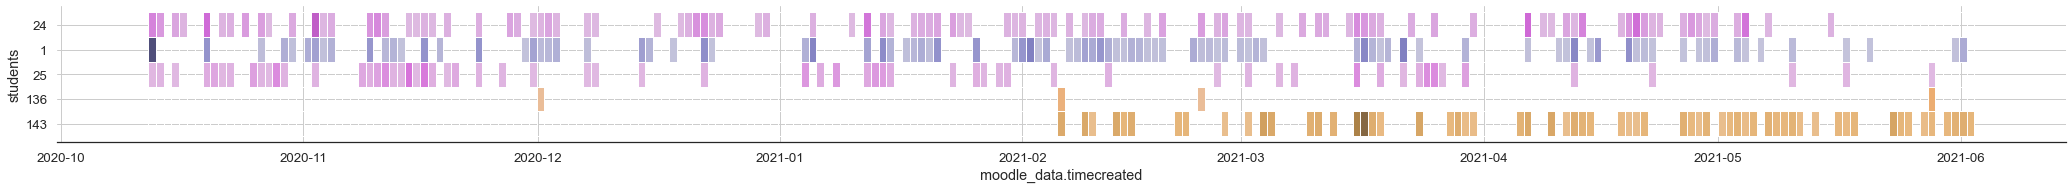

In [26]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, (md.userid[md.userstatus == 'student'].unique().size / 2))) # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge pro Student über 235 Tage (Gesamtzeitraum)
chart = sns.histplot(x=md.timecreated, y=md.userid[md.userstatus == 'student'].astype(str), bins=235, hue=md.userid, hue_order=np.sort(md.userid.unique()), palette='rocket', edgecolor='white', legend=False)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('students')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Evaluierung_der_Kontinuitaet_Log-Eintraege_nach_Tagen.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Student

In [27]:
# Ermittlung der Menge der Log-Einträge pro Student
loggings_user = pd.Series(md.userid[md.userstatus == 'student'].groupby(md.userid).count(), name='loggings')
# display(loggings_user)

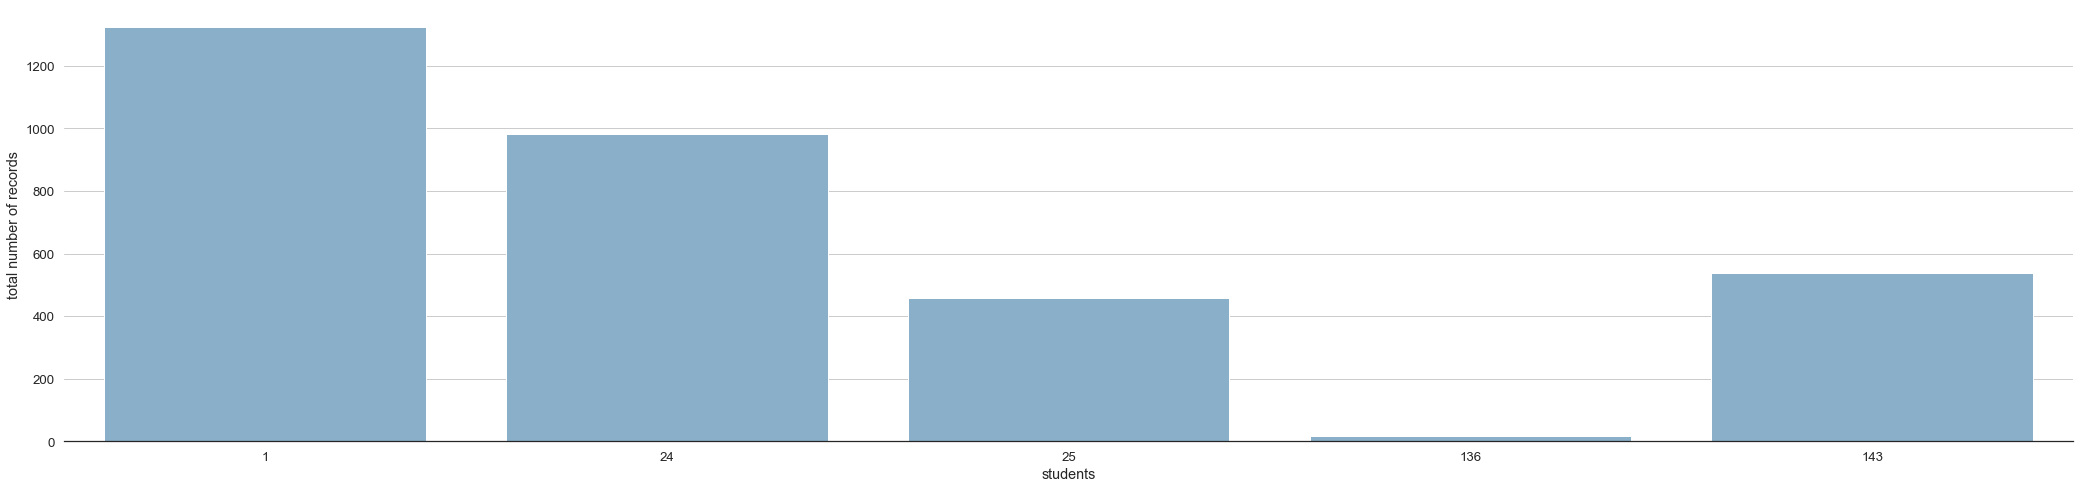

In [28]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Menge der Log-Einträge pro Student
chart = sns.barplot(x=loggings_user.index.astype(int), y=loggings_user, color=colors_set3[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Analyse_der_Kontinuitaet_Log-Eintraege_pro_Student.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Arbeitstage pro Student

In [29]:
# Ermittlung der Menge der Arbeitstage pro Student
days_user = pd.Series(md.year_day[md.userstatus == 'student'].groupby(md.userid).nunique(), name='days')
# display(days_user)

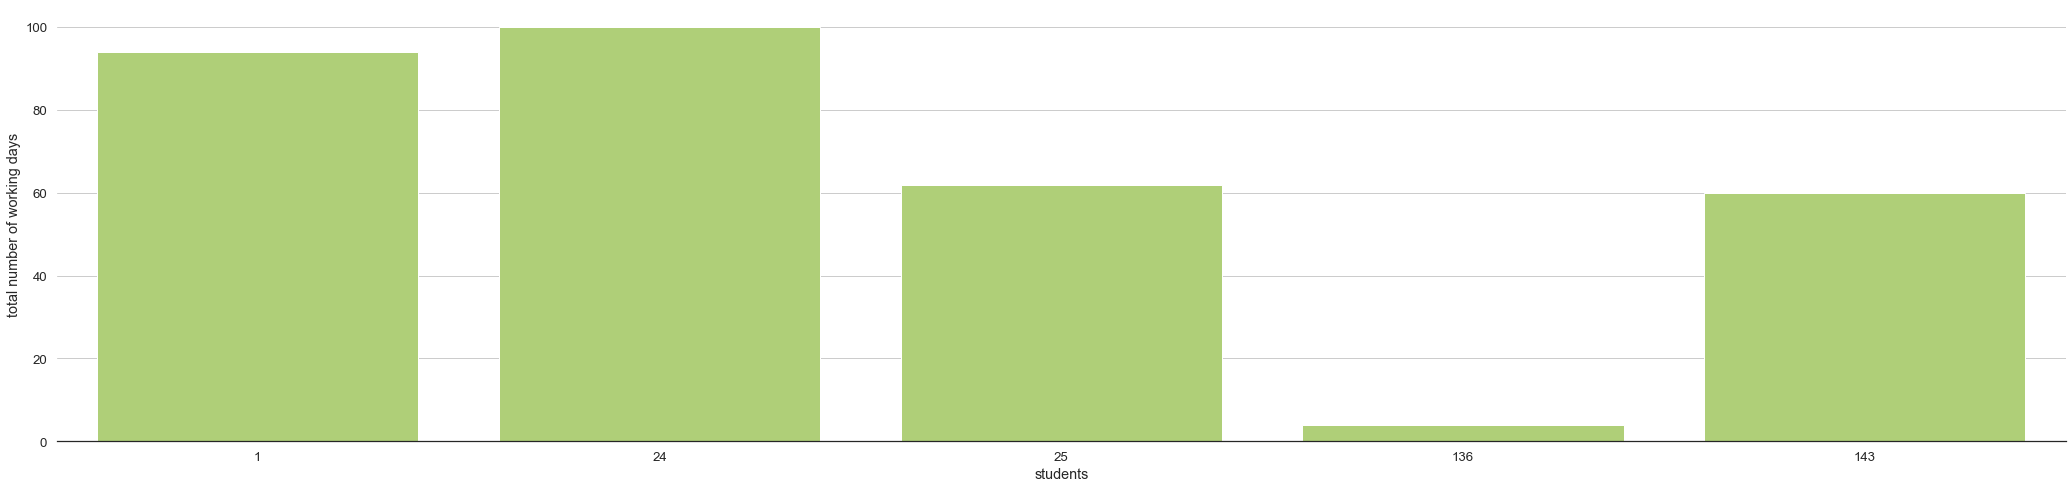

In [30]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 8))  # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Menge der Arbeitstage pro Student
chart = sns.barplot(x=days_user.index.astype(int), y=days_user, color=colors_set3[6])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_xlabel('students')
chart.set_ylabel('total number of working days')
sns.despine(left=True)
# plt.savefig('charts/Menge_der_Arbeitstage_im_Gesamtzeitraum_pro_Student.pdf', format='pdf')
plt.show()

&nbsp;
#### Ermittlung der Unterscheidungskriterien

&nbsp;
**Erstellung des neuen Datensets _time_relation_ zur Aufnahme individueller Kennziffern**

In [31]:
# Erstellung eines neuen Datensets, bestehend aus den absoluten Mengen der Log-Einträge und der Arbeitstage pro Student
time_relation = pd.concat([loggings_user, days_user], axis=1)

# Erstellung einer neuen Spalte zur Aufnahme der durchschnittlichen Mengen der Log-Einträge pro Arbeitstag
time_relation['avg_count_per_day'] = 0
# Berechnung der Werte für die durchschnittlichen Mengen der Log-Einträge pro Arbeitstag
time_relation.loc[(time_relation['avg_count_per_day'] == 0), ['avg_count_per_day']] = (loggings_user / days_user).astype(int)

time_relation.reset_index(inplace=True)
display(time_relation)

userid  loggings  days  avg_count_per_day
0       1      1324    94                 14
1      24       983   100                  9
2      25       457    62                  7
3     136        18     4                  4
4     143       538    60                  8

&nbsp;
**Ausgabe der durchschnittlichen Mengen an Log-Einträgen pro Arbeitstag und Student**

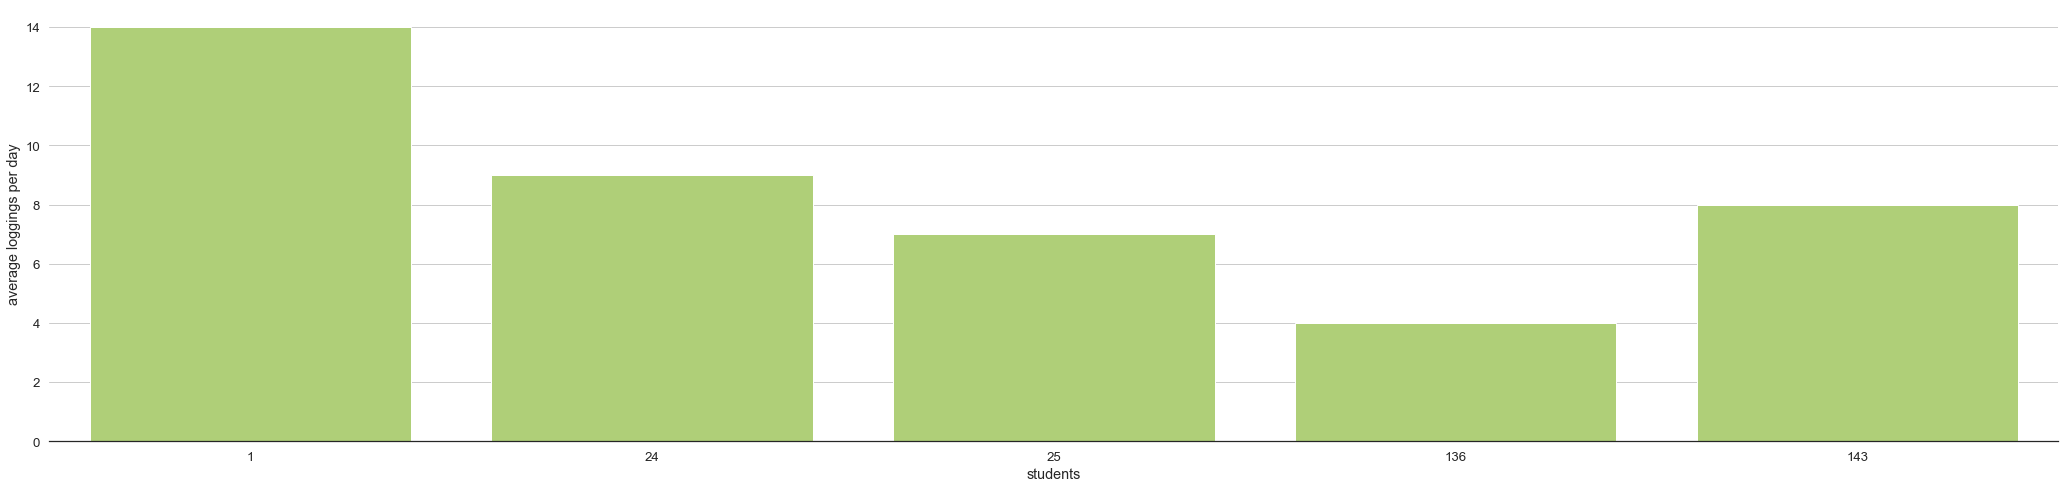

In [32]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 8))  # Größe der Visualisierung (in inch)

# Visualisierung der durchschnittlichen Menge an Log-Einträgen pro Arbeitstag und Student
chart = sns.barplot(x=time_relation.userid.astype(int), y=time_relation['avg_count_per_day'], color=colors_set3[6])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_xlabel('students')
chart.set_ylabel('average loggings per day')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Ermittlung der Mengen der Arbeitstage mit überdurchschnittlichen Mengen an Log-Einträgen pro Student**

In [33]:
# Deklaration eines einfachen Listen-Objekts zur Aufnahme der ermittelten Tage pro Student
list_days_above_average = list()

# Funktion zur Ermittlung der Menge der Arbeitstage, an denen die Menge der Log-Einträge pro Arbeitstag über dem Gesamtdurchschnitt lag
def get_days_above_average(i, list_days_above_average):
    count = 0
    for row in md.year_day[(md.userid == time_relation.iloc[i]['userid']) & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))].groupby(md.year_day).count():
        if row < time_relation.iloc[i]['avg_count_per_day']:
            count += 1
    list_days_above_average.append(count)

# Schleife zur Steuerung der Ermittlungsfunktion
for i in time_relation.index:
    get_days_above_average(i, list_days_above_average)

# Erstellung eines DataFrame-kompatiblen Series-Objekts
days_above_average = pd.Series(list_days_above_average, name='days_above_average', dtype='int32')

# Ausgabe des Ergebnisses
display(days_above_average)

0    64
1    61
2    40
3     2
4    34
Name: days_above_average, dtype: int32

&nbsp;
**Ermittlung der Mengen der Arbeitstage mit unterdurchschnittlichen Mengen an Log-Einträgen pro Student**

In [34]:
# Deklaration eines einfachen Listen-Objekts zur Aufnahme der ermittelten Tage pro Student
list_days_below_average = list()

# Funktion zur Ermittlung der Menge der Arbeitstage, an denen die Menge der Log-Einträge pro Arbeitstag unter dem Gesamtdurchschnitt lag
def get_days_below_average(i, list_days_below_average):
    count = 0
    for row in md.year_day[(md.userid == time_relation.iloc[i]['userid']) & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))].groupby(md.year_day).count():
        if row > time_relation.iloc[i]['avg_count_per_day']:
            count += 1
    list_days_below_average.append(count)

# Schleife zur Steuerung der Ermittlungsfunktion
for i in time_relation.index:
    get_days_below_average(i, list_days_below_average)

# Erstellung eines DataFrame-kompatiblen Series-Objekts
days_below_average = pd.Series(list_days_below_average, name='days_below_average', dtype='int32')

# Ausgabe des Ergebnisses
display(days_below_average)

0    29
1    33
2    17
3     2
4    21
Name: days_below_average, dtype: int32

&nbsp;
**Ergänzung der Mengen an Arbeitstagen mit über- und unterdurchschnittlichen Mengen an Log-Einträgen**

In [35]:
# Ergänzung des Datensets mit den Mengen an Arbeitstagen, die über- bzw. unterhalb des Gesamtdurchschnitts lagen.
time_relation = pd.concat([time_relation, days_above_average, days_below_average], axis=1)
pd.set_option('display.max_rows', None)
display(time_relation)

userid  loggings  days  avg_count_per_day  days_above_average  \
0       1      1324    94                 14                  64   
1      24       983   100                  9                  61   
2      25       457    62                  7                  40   
3     136        18     4                  4                   2   
4     143       538    60                  8                  34   

   days_below_average  
0                  29  
1                  33  
2                  17  
3                   2  
4                  21

&nbsp;
**Ermittlung des individuellen Dynamikkoeffizienten (IDK)**

In [36]:
# Deklaration eines leeren Listen-Objekts zur Aufnahme des individuellen Dynamikoeffizienten (IDK) pro Student
list_idk = list()

# Funktion zur Ermittlung des individuellen Dynamikoeffizienten (IDK)
def get_idk(i, list_idk, days_in_period, days_in_period_count):
    days_user = md.timecreated[md.userid == time_relation.iloc[i]['userid']].sort_values().dt.dayofyear.unique() # Array mit individuellen Arbeitstagen
    x = 1
    idk = 0
    for d in days_in_period:
        if d in days_user:
            for row in md.year_day[(md.semesterperiod == 'before_exams1') & (md.userid == time_relation.iloc[i]['userid']) & (md.year_day == d) & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))].groupby(md.year_day).count():
                idk += (row - time_relation.iloc[i]['avg_count_per_day']) * (x / days_in_period_count)
        else:
            idk += (0 - time_relation.iloc[i]['avg_count_per_day']) * (x / days_in_period_count)
        x += 1
    list_idk.append(idk)

# Schleife zur Steuerung der Ermittlungsfunktion
for i in time_relation.index:
    get_idk(i, list_idk, days_in_period, days_in_period_count)

# Erstellung eines DataFrame-kompatiblen Series-Objekts
idk = pd.Series(list_idk, name='idk')

# Ausgabe des Ergebnisses
display(idk)

0   -307.750000
1   -237.238636
2   -166.784091
3   -177.420455
4   -356.000000
Name: idk, dtype: float64

&nbsp;
**Ergänzung des individuellen Dynamikkoeffizienten (IDK)**

In [37]:
# Ergänzung des individuellen Dynmamikkoeffizienten (IDK) im Datenset time_relation
time_relation = pd.concat([time_relation, idk], axis=1)
pd.set_option('display.max_rows', None)
display(time_relation)

userid  loggings  days  avg_count_per_day  days_above_average  \
0       1      1324    94                 14                  64   
1      24       983   100                  9                  61   
2      25       457    62                  7                  40   
3     136        18     4                  4                   2   
4     143       538    60                  8                  34   

   days_below_average         idk  
0                  29 -307.750000  
1                  33 -237.238636  
2                  17 -166.784091  
3                   2 -177.420455  
4                  21 -356.000000

&nbsp;
**Typisierung der Studenten nach der Dynamik ihrer Aktivitäten**

In [38]:
# Erstellung einer neuen Spalte zur Typisierung
time_relation['dynamic'] = 'standard'

# Einordnung der Studenten nach der Dynamik ihrer Aktivitäten
time_relation.loc[(time_relation['idk'] > 0), ['dynamic']] = 'positive'
time_relation.loc[(time_relation['idk'] < 0), ['dynamic']] = 'negative'
display(time_relation)

userid  loggings  days  avg_count_per_day  days_above_average  \
0       1      1324    94                 14                  64   
1      24       983   100                  9                  61   
2      25       457    62                  7                  40   
3     136        18     4                  4                   2   
4     143       538    60                  8                  34   

   days_below_average         idk   dynamic  
0                  29 -307.750000  negative  
1                  33 -237.238636  negative  
2                  17 -166.784091  negative  
3                   2 -177.420455  negative  
4                  21 -356.000000  negative

&nbsp;
#### Anwendung der Unterscheidungskriterien

&nbsp;
**Typisierung der Studenten nach IDK**

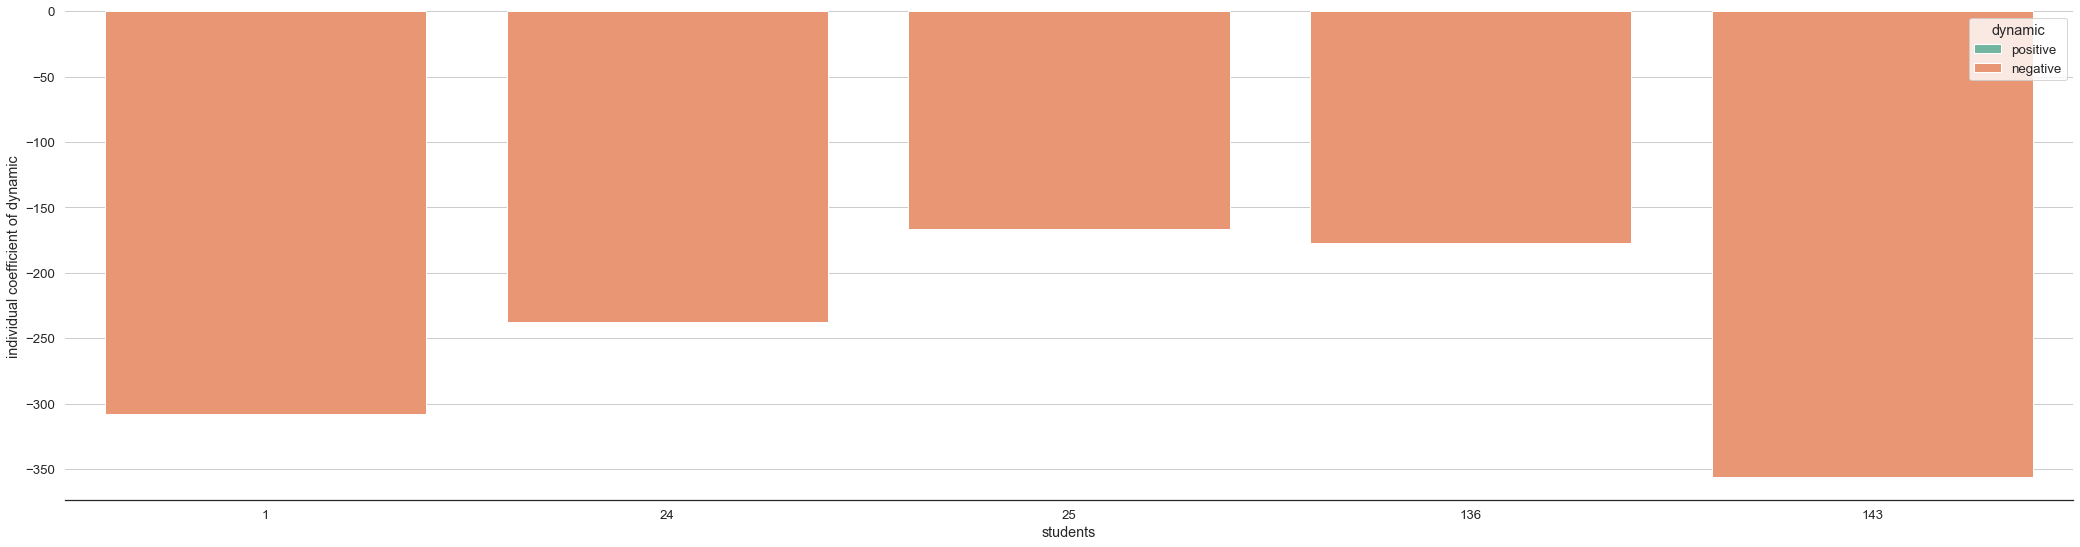

In [39]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Typisierung der Studenten nach individuellem Dynmamikkoeffizienten
chart = sns.barplot(x=time_relation.userid.astype(int), y=time_relation.idk, hue=time_relation.dynamic, hue_order=['positive', 'negative'], dodge=False, palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
# chart.yaxis.set_ticks(np.arange(0, 1.1, step=0.1))
chart.set_xlabel('students')
chart.set_ylabel('individual coefficient of dynamic')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.legend(title='dynamic', loc='upper right')
# plt.savefig('charts/Typisierung_nach_Dynamik_IDK.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach IDK mit Bezug auf die absolute Menge der Log-Einträge pro Student**

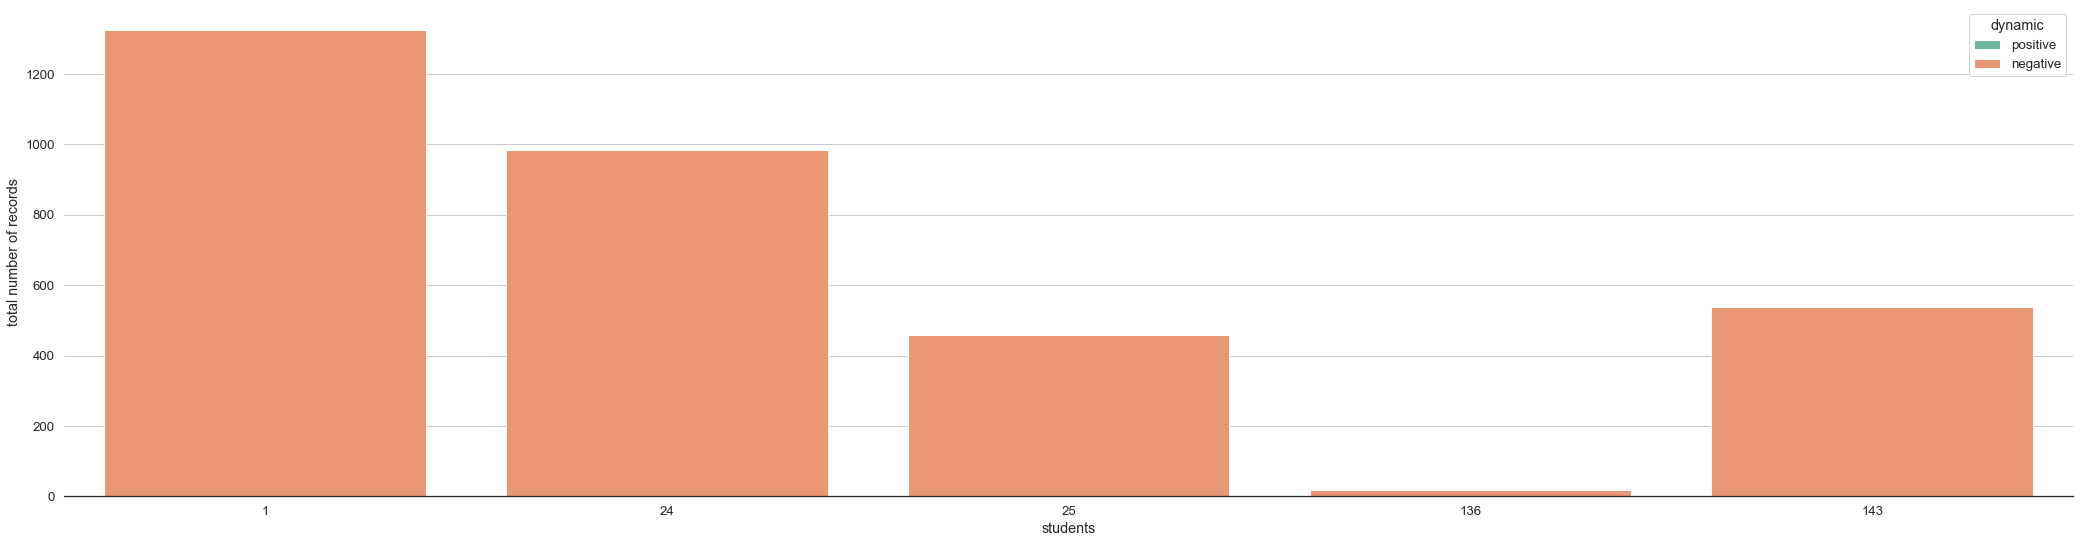

In [40]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Typisierung der Studenten nach IDK mit Bezug auf die absolute Menge der Log-Einträge pro Student
chart = sns.barplot(x=time_relation.userid.astype(int), y=time_relation.loggings, hue=time_relation.dynamic, hue_order=['positive', 'negative'], dodge=False, palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.legend(title='dynamic', loc='upper right')
# plt.savefig('charts/Typisierung_nach_Dynamik_Log-Eintraege.pdf', format='pdf')
plt.show()